In [29]:
import sys
import os
import numpy as np
import scipy as sp
import pandas as pd
import tensorflow as tf
from tensorflow.core.framework import graph_pb2
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.python.platform import gfile

from time import time
import seaborn as sns
from scipy.spatial import distance_matrix

In [6]:
def feat_Logits_batch(images, model_path):
    tf.reset_default_graph()
    graph_def = graph_pb2.GraphDef()
    print(model_path)
    with open(model_path, "rb") as f:
        graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def)
    # Resize image
    resized_images = np.zeros((len(images),299,299,3))
    for i,image in enumerate(images):
        img = Image.open(image)
        img = img.resize((299, 299))
        imgnumpy = np.ndarray((1,299,299,3))
        resized_images[i] = img
    resized_images/=255
    
    # starting a TF session
    with tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=1, device_count={'GPU': 2})) as sess:
#     with tf.Session() as sess:
        t_prediction = sess.graph.get_tensor_by_name('import/InceptionV3/Predictions/Reshape_1:0')
        t_fully_conn = sess.graph.get_tensor_by_name('import/InceptionV3/Logits/SpatialSqueeze:0')
        t_dropout    = sess.graph.get_tensor_by_name('import/InceptionV3/Logits/Dropout_1b/Identity:0')
        t_avg_pool   = sess.graph.get_tensor_by_name('import/InceptionV3/Logits/AvgPool_1a_8x8/AvgPool:0')
        
        avg_pool, dropout, fully_conn, prediction = sess.run([t_avg_pool, t_dropout, t_fully_conn, t_prediction],\
                              feed_dict={'import/input:0': resized_images})
        
    return np.squeeze(avg_pool), np.squeeze(dropout), np.squeeze(fully_conn), np.squeeze(prediction)

In [3]:
images_flat = pd.read_csv('/lustre/MHPC17/pierocor/nffa-dr/images_flat_script/images_flat.csv', sep='\t')
X = images_flat.loc[(images_flat['scale_unit'] == 'μm') & \
                     ( (images_flat['scale_digit'] == 1) | (images_flat['scale_digit'] == 2) )]

In [4]:
sample_indices = []
np.random.seed(42) # SEED!!!!! default: 42
print("cat\tN_cat\tN_samples")
for cat in range(10):
    N_cat = len(X.loc[X['nffa_category']==cat])
    N_samples = min(max(N_cat//20, 20),N_cat)
    print(cat,'\t', N_cat,'\t', N_samples)
    sample_indices += X.loc[X['nffa_category']==cat].index[np.random.choice(N_cat,\
                                                                            size=N_samples,\
                                                                            replace=False)].tolist()
print("Total samples:\t", len(sample_indices))
root_dir = '/lustre/exact/SEM-images/images_flat/'
filename = list(root_dir + X['subdir'].loc[sample_indices] + '/' + X['hash_tif'].loc[sample_indices] + '.jpg')

cat	N_cat	N_samples
0 	 55 	 20
1 	 1403 	 70
2 	 933 	 46
3 	 147 	 20
4 	 236 	 20
5 	 713 	 35
6 	 1891 	 94
7 	 588 	 29
8 	 1572 	 78
9 	 19 	 19
Total samples:	 431


In [49]:
discrete_dist = np.ones((len(sample_indices),len(sample_indices)), dtype=int)
for i,index in enumerate(sample_indices):
    discrete_dist[i,:]= X['nffa_category'].loc[sample_indices]!=X['nffa_category'].loc[index]

In [27]:
batches = [filename[:len(filename)//2], filename[len(filename)//2:]]
res = []
model_path ='/u/MHPC17/pierocor/thesis/models/inception_v3_frozen_train-on-nffa_lr0.01-exp-dec_wd0.0001_ep10_bs32.pb'
print("Inference on",len(filename), "images.")
for i, batch in enumerate(batches):
    start = time()
    res.append(feat_Logits_batch(batch, model_path))
    stop = time()
    print(i, stop - start, "sec")

avg_pool = np.vstack([res[0][0], res[1][0]])
dropout = np.vstack([res[0][1], res[1][1]])
fully_conn = np.vstack([res[0][2], res[1][2]])
prediction = np.vstack([res[0][3], res[1][3]])

Inference on 431 images.
/u/MHPC17/pierocor/thesis/models/inception_v3_frozen_train-on-nffa_lr0.01-exp-dec_wd0.0001_ep10_bs32.pb
0 12.417396306991577 sec
/u/MHPC17/pierocor/thesis/models/inception_v3_frozen_train-on-nffa_lr0.01-exp-dec_wd0.0001_ep10_bs32.pb
1 10.836897611618042 sec


In [53]:
dist = distance_matrix(avg_pool,avg_pool)
R_corr = np.array([sp.stats.pearsonr(dist[i], discrete_dist[i])[0] for i in range(len(sample_indices))])
print(np.mean(R_corr[np.isfinite(R_corr)]))
print(sp.stats.pearsonr(dist.reshape((-1,)), discrete_dist.reshape((-1,))))
s_corr = np.array([sp.stats.spearmanr(dist[i], discrete_dist[i])[0] for i in range(len(sample_indices))])
print(np.mean(s_corr[np.isfinite(R_corr)]))
print(sp.stats.spearmanr(dist.reshape((-1,)), discrete_dist.reshape((-1,))))

dist = distance_matrix(prediction,prediction)
print()

print(sp.stats.spearmanr(dist.reshape((-1,)), discrete_dist.reshape((-1,))))

0.5530003601451984
(0.49167732743805403, 0.0)
0.47369143825934934
SpearmanrResult(correlation=0.46094849563863377, pvalue=0.0)
0.8434272638403348
(0.8547428547792548, 0.0)
0.5296504875048212
SpearmanrResult(correlation=0.5596101331420872, pvalue=0.0)


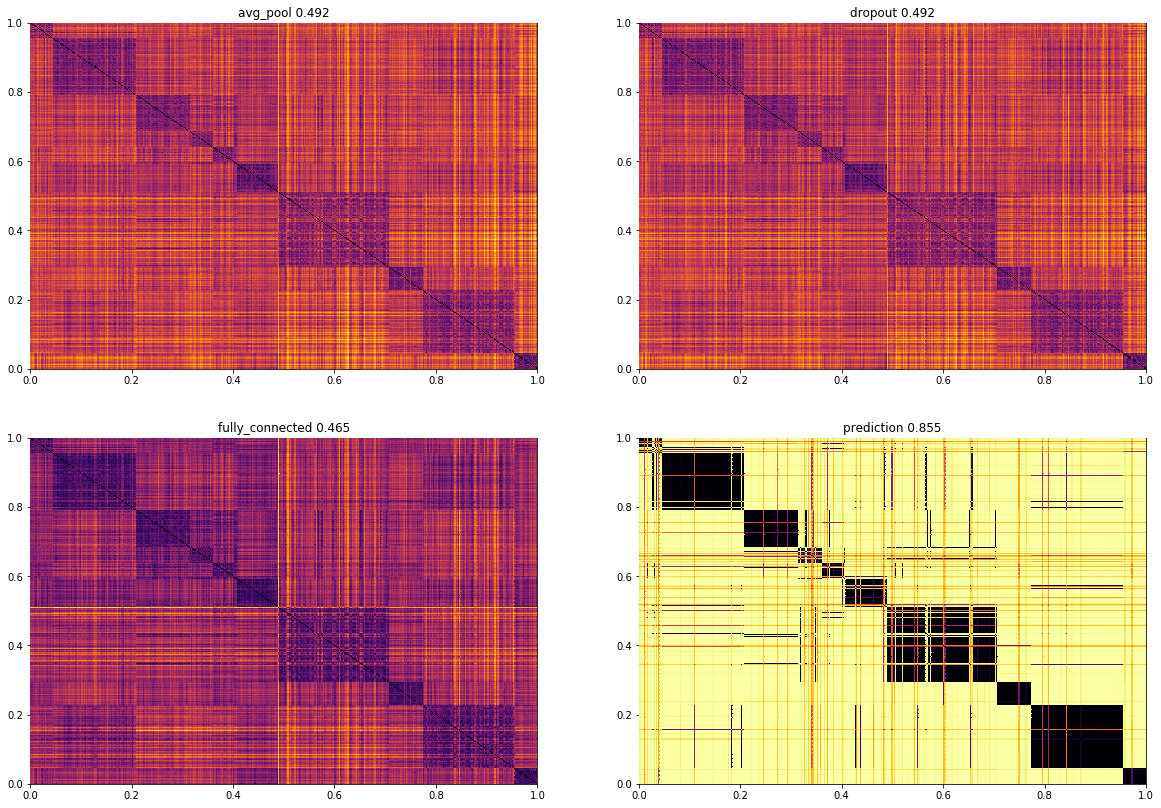

In [59]:
fig,axn = plt.subplots(2, 2, figsize=(20,14))
fig.add_subplot(2,2,1)
dist = distance_matrix(avg_pool,avg_pool)
plt.title("avg_pool "+"{:.3f}".format(sp.stats.pearsonr(dist.reshape((-1,)), discrete_dist.reshape((-1,)))[0]))
sns.heatmap(dist, cmap=plt.get_cmap("inferno"),cbar=False, xticklabels=False, yticklabels=False)

fig.add_subplot(2,2,2)
dist = distance_matrix(dropout,dropout)
plt.title("dropout "+"{:.3f}".format(sp.stats.pearsonr(dist.reshape((-1,)), discrete_dist.reshape((-1,)))[0]))
sns.heatmap(dist, cmap=plt.get_cmap("inferno"),cbar=False, xticklabels=False, yticklabels=False)

fig.add_subplot(2,2,3)
dist = distance_matrix(fully_conn,fully_conn)
plt.title("fully_connected "+"{:.3f}".format(sp.stats.pearsonr(dist.reshape((-1,)), discrete_dist.reshape((-1,)))[0]))
sns.heatmap(dist, cmap=plt.get_cmap("inferno"),cbar=False, xticklabels=False, yticklabels=False)

fig.add_subplot(2,2,4)
dist = distance_matrix(prediction,prediction)
plt.title("prediction "+"{:.3f}".format(sp.stats.pearsonr(dist.reshape((-1,)), discrete_dist.reshape((-1,)))[0]))
sns.heatmap(dist, cmap=plt.get_cmap("inferno"),cbar=False, xticklabels=False, yticklabels=False)

In [60]:
batches = [filename[:len(filename)//2], filename[len(filename)//2:]]
res = []
model_path ='/u/MHPC17/pierocor/thesis/models/inception_v3_frozen_train-on-ILSVRC-2012-CLS_slim_2016_08_28.pb'
print("Inference on",len(filename), "images.")
for i, batch in enumerate(batches):
    start = time()
    res.append(feat_Logits_batch(batch, model_path))
    stop = time()
    print(i, stop - start, "sec")

avg_pool = np.vstack([res[0][0], res[1][0]])
dropout = np.vstack([res[0][1], res[1][1]])
fully_conn = np.vstack([res[0][2], res[1][2]])
prediction = np.vstack([res[0][3], res[1][3]])

Inference on 431 images.
/u/MHPC17/pierocor/thesis/models/inception_v3_frozen_train-on-ILSVRC-2012-CLS_slim_2016_08_28.pb
0 11.73506474494934 sec
/u/MHPC17/pierocor/thesis/models/inception_v3_frozen_train-on-ILSVRC-2012-CLS_slim_2016_08_28.pb
1 11.450156927108765 sec


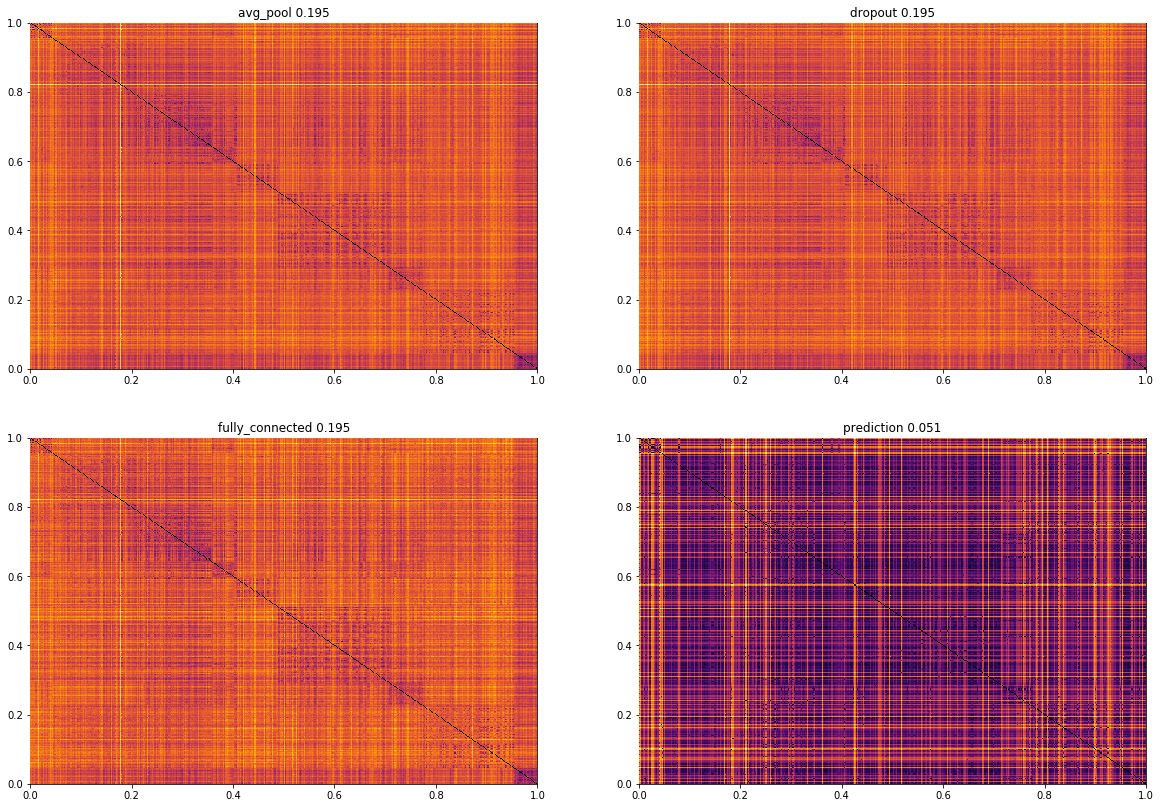

In [62]:
fig,axn = plt.subplots(2, 2, figsize=(20,14))
fig.add_subplot(2,2,1)
dist = distance_matrix(avg_pool,avg_pool)
plt.title("avg_pool "+"{:.3f}".format(sp.stats.pearsonr(dist.reshape((-1,)), discrete_dist.reshape((-1,)))[0]))
sns.heatmap(dist, cmap=plt.get_cmap("inferno"),cbar=False, xticklabels=False, yticklabels=False)

fig.add_subplot(2,2,2)
dist = distance_matrix(dropout,dropout)
plt.title("dropout "+"{:.3f}".format(sp.stats.pearsonr(dist.reshape((-1,)), discrete_dist.reshape((-1,)))[0]))
sns.heatmap(dist, cmap=plt.get_cmap("inferno"),cbar=False, xticklabels=False, yticklabels=False)

fig.add_subplot(2,2,3)
dist = distance_matrix(fully_conn,fully_conn)
plt.title("fully_connected "+"{:.3f}".format(sp.stats.pearsonr(dist.reshape((-1,)), discrete_dist.reshape((-1,)))[0]))
sns.heatmap(dist, cmap=plt.get_cmap("inferno"),cbar=False, xticklabels=False, yticklabels=False)

fig.add_subplot(2,2,4)
dist = distance_matrix(prediction,prediction)
plt.title("prediction "+"{:.3f}".format(sp.stats.pearsonr(dist.reshape((-1,)), discrete_dist.reshape((-1,)))[0]))
sns.heatmap(dist, cmap=plt.get_cmap("inferno"),cbar=False, xticklabels=False, yticklabels=False)